In [159]:
import scipy as sp
import numpy as np
import pandas as pd
import sklearn
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta, datetime
import re
import timeit


pd.options.display.max_rows = 4000

In [160]:
# Pulling data from ANRGUSC github
df = pd.read_csv('https://raw.githubusercontent.com/ANRGUSC/covid19_risk_estimation/master/data/Covid-19-R.csv')



# Pulling data from ANRGUSC github
df = pd.read_csv('https://raw.githubusercontent.com/ANRGUSC/covid19_risk_estimation/master/data/Covid-19-R.csv')
df_infection = pd.read_csv('https://raw.githubusercontent.com/ANRGUSC/covid19_risk_estimation/master/data/Covid-19.csv')
df_county_names = pd.read_csv('county_storage.csv')

# Converting String into Datetime data type
df['Time Stamp'] = pd.to_datetime(df['Time Stamp'])  
df_infection['Time Stamp'] = pd.to_datetime(df_infection['Time Stamp'])  

# Dropping 'Latitude' and 'Longitude' columns from df_infection
df_infection = df_infection.drop(['Latitude', 'Longitude'], axis=1)

# Combining two tables together
df = pd.merge(df, df_infection,  how='left', left_on=['Time Stamp','Region'], right_on = ['Time Stamp','Region'])

# Changing Region Name to Upper Case

df['Region'] = df['Region'].str.upper()

In [161]:

# Converting String into Datetime data type
df['Time Stamp'] = pd.to_datetime(df['Time Stamp'])

# Dropping Any Data with no Risk Score
df=df[df['Risk-Score']!=-1]

# renaming the first column to index
df=df.rename(columns={"Unnamed: 0": "index"})


In [162]:
# Defining LA county and LA city 


unique_regions = df_county_names['location'].unique()


pattern="^LOS ANGELES - "

extr_region=df_county_names['location'].str.contains(pattern)
los_angeles_region = df_county_names[extr_region]['location']


los_angeles_region=los_angeles_region.str.replace('LOS ANGELES - ','').unique()

los_angeles_region
        

array(['ADAMS-NORMANDIE', 'ALSACE', 'ANGELINO HEIGHTS', 'ARLETA',
       'ATWATER VILLAGE', 'BALDWIN HILLS', 'BEL AIR', 'BEVERLY CREST',
       'BEVERLYWOOD', 'BOYLE HEIGHTS', 'BRENTWOOD', 'BROOKSIDE',
       'CADILLAC-CORNING', 'CANOGA PARK', 'CARTHAY', 'CENTRAL',
       'CENTURY CITY', 'CENTURY PALMS/COVE', 'CHATSWORTH',
       'CHEVIOT HILLS', 'CHINATOWN', 'CLOVERDALE/COCHRAN',
       'COUNTRY CLUB PARK', 'CRENSHAW DISTRICT', 'CRESTVIEW', 'DEL REY',
       'DOWNTOWN', 'EAGLE ROCK', 'EAST HOLLYWOOD', 'ECHO PARK',
       'EL SERENO', 'ELYSIAN PARK', 'ELYSIAN VALLEY', 'ENCINO',
       'EXPOSITION', 'EXPOSITION PARK', 'FAIRCREST HEIGHTS',
       'FIGUEROA PARK SQUARE', 'FLORENCE-FIRESTONE', 'GLASSELL PARK',
       'GRAMERCY PLACE', 'GRANADA HILLS', 'GREEN MEADOWS', 'HANCOCK PARK',
       'HARBOR CITY', 'HARBOR GATEWAY', 'HARBOR PINES', 'HARVARD HEIGHTS',
       'HARVARD PARK', 'HIGHLAND PARK', 'HISTORIC FILIPINOTOWN',
       'HOLLYWOOD', 'HOLLYWOOD HILLS', 'HYDE PARK', 'JEFFERSON PARK',

In [163]:
regions = df['Region'].unique()
df_new=df.copy()

df_new_cases = pd.DataFrame()

for region in regions:
    df_region = df_new[df_new['Region']==region].sort_values('Time Stamp')
    for date in df_region['Time Stamp']:
        day_before = date - dt.timedelta(days=1)
        df_on_day = df_region[df_region['Time Stamp']==date]
        
        cases_on_day = df_on_day['Number of cases']
        cases_day_before = df_region[df_region['Time Stamp']==day_before]['Number of cases']
        
        if not cases_day_before.empty:
            new_cases = cases_on_day.iloc[0] - cases_day_before.iloc[0]
        
        
            new_row = {'index':df_on_day['index'].iloc[0], 'New Cases':new_cases}
        #append row to the dataframe
            df_new_cases = df_new_cases.append(new_row, ignore_index=True)
    
df_new_cases

,New Cases,index
0,-1.0,30.0
1,0.0,72.0
2,1.0,117.0
3,1.0,186.0
4,0.0,268.0
...,...,...
34578,11.0,32268.0
34579,10.0,32508.0
34580,23.0,32748.0
34581,16.0,32988.0


In [164]:
# Adding new cases data into df
df = pd.merge(left=df, right=df_new_cases, how='left', on='index')

In [165]:
# Finding out what different levels mean

df_0 = df[df['Risk-Level']==0]['Risk-Score']
df_1 = df[df['Risk-Level']==1]['Risk-Score']
df_2 = df[df['Risk-Level']==2]['Risk-Score']
df_3 = df[df['Risk-Level']==3]['Risk-Score']

print("level 0 is between %f and %f" %(min(df_0),max(df_0)))
print("level 1 is between %f and %f" %(min(df_1),max(df_1)))
print("level 2 is between %f and %f" %(min(df_2),max(df_2)))
print("level 3 is between %f and %f" %(min(df_3),max(df_3)))

level 0 is between 0.000000 and 0.099892
level 1 is between 0.100022 and 0.999895
level 2 is between 1.000413 and 1.999766
level 3 is between 2.000270 and 365.147400


In [166]:
for r in df['Region']:
    r=r
    a=los_angeles_region
    print(r in a)

False
False
False
True
False
False
True
False
False
False
True
False
False
False
False
True
True
False
True
False
True
True
True
False
True
True
True
False
True
True
False
False
False
True
False
True
True
False
False
False
True
True
False
False
True
True
True
False
False
False
False
True
True
False
True
True
True
False
True
False
True
True
True
False
True
True
True
False
True
True
True
False
False
True
False
True
True
False
True
False
False
True
True
False
False
True
True
True
False
False
False
False
True
True
False
True
True
True
False
True
False
True
True
True
True
False
True
False
True
True
False
True
True
True
True
False
False
True
False
True
True
True
False
False
False
False
False
True
False
False
True
False
True
True
False
False
True
True
False
True
True
False
False
False
False
False
False
True
True
False
True
True
True
True
True
True
False
True
False
False
True
False
True
True
True
False
True
True
True
True
True
True
False
True
True
False
True
True
True
True
False
True
False
Fal

True
True
False
True
False
False
True
False
True
True
False
True
False
True
False
False
True
False
False
True
False
False
False
True
False
True
True
False
True
True
False
True
False
True
False
False
True
False
True
True
True
False
True
True
True
False
True
False
False
True
False
True
True
False
False
True
False
False
True
False
True
True
False
True
False
False
True
True
True
True
True
True
True
True
True
False
True
False
False
True
True
True
False
True
True
True
True
True
True
False
False
False
False
True
True
True
True
False
True
False
False
False
True
True
False
False
False
False
False
True
True
False
True
False
False
False
True
True
True
True
True
False
True
True
False
False
True
True
False
True
True
False
True
True
True
True
False
False
False
True
True
True
True
False
True
True
True
False
True
False
True
False
True
False
False
True
True
True
False
True
False
True
False
True
True
True
True
False
False
False
False
False
False
False
False
True
False
False
False
True
True
False
False
T

True
True
True
True
True
False
False
False
False
True
True
True
True
False
True
False
False
False
True
True
False
False
False
False
False
True
True
False
True
False
False
False
True
True
True
True
True
False
True
True
False
False
True
True
False
True
True
False
True
True
True
True
False
False
False
True
True
True
True
False
True
True
True
False
True
False
True
False
True
False
False
True
True
True
False
True
False
True
False
True
True
True
True
False
False
False
False
False
False
False
False
True
False
False
False
True
True
False
False
True
True
False
False
True
False
False
True
True
True
True
True
True
True
False
True
True
True
True
True
False
True
True
True
False
True
True
True
True
True
True
True
False
True
True
True
False
True
True
True
False
True
False
True
True
False
True
True
False
True
False
True
False
True
True
True
True
False
True
False
False
True
False
True
True
False
True
False
True
False
False
True
False
False
True
False
False
False
True
False
True
True
False
True
True
Fal

True
True
False
False
True
False
False
True
True
True
True
True
True
True
False
True
True
True
True
True
False
True
True
True
False
True
True
True
True
True
True
True
False
True
True
True
False
True
True
True
False
True
False
True
True
False
True
True
False
True
False
True
False
True
True
True
True
False
True
True
False
True
True
True
True
False
False
True
False
True
False
True
True
True
True
True
False
True
False
True
False
False
True
False
True
True
True
False
True
True
True
False
True
False
False
True
False
True
True
False
False
True
False
False
True
False
True
True
False
True
False
False
True
True
True
True
True
True
True
True
True
False
True
False
False
True
True
True
False
True
True
True
True
True
True
False
False
False
False
True
True
True
True
False
True
False
False
False
True
True
False
False
False
False
False
True
True
False
True
False
False
False
True
True
True
True
True
False
True
True
False
False
True
True
False
True
True
False
True
True
True
True
False
False
False
True
Tr

True
False
False
True
True
False
True
True
False
True
True
True
True
False
False
False
True
True
True
True
False
True
True
True
False
True
False
True
False
True
False
False
True
True
True
False
True
False
True
False
True
True
True
True
False
False
False
False
False
False
False
False
True
False
False
False
True
True
False
False
True
True
False
False
True
False
False
True
True
True
True
True
True
True
False
True
True
True
True
True
False
True
True
True
False
True
True
True
True
True
True
True
False
True
True
True
False
True
True
True
False
True
False
True
True
False
True
True
False
True
False
True
False
True
True
True
True
False
True
False
False
True
False
True
True
False
True
False
True
False
False
True
False
False
True
False
False
False
True
False
True
True
False
True
True
False
True
False
True
False
False
True
False
True
True
True
False
True
True
True
False
True
False
False
True
False
True
True
False
False
True
False
False
True
False
True
True
False
True
False
False
True
True
True
Tru

False
False
False
False
True
False
False
False
True
True
False
False
True
True
False
False
True
False
False
True
True
True
True
True
True
True
False
True
True
True
True
True
False
True
True
True
False
True
True
True
True
True
True
True
False
True
True
True
False
True
True
True
False
True
False
True
True
False
True
True
False
True
False
True
False
True
True
True
True
False
True
False
False
True
False
True
True
False
True
False
True
False
False
True
False
False
True
False
False
False
True
False
True
True
False
True
True
False
True
False
True
False
False
True
False
True
True
True
False
True
True
True
False
True
False
False
True
False
True
True
False
False
True
False
False
True
False
True
True
False
True
False
False
True
True
True
True
True
True
True
True
True
False
True
False
False
True
True
True
False
True
True
True
True
True
True
False
False
False
False
True
True
True
True
False
True
False
False
False
True
True
False
False
False
False
False
True
True
False
True
False
False
False
True
Tr

False
False
True
False
True
True
False
True
False
False
True
True
True
True
True
True
True
True
True
False
True
False
False
True
True
True
False
True
True
True
True
True
True
False
False
False
False
True
True
True
True
False
True
False
False
False
True
True
False
False
False
False
False
True
True
False
True
False
False
False
True
True
True
True
True
False
True
True
False
False
True
True
False
True
True
False
True
True
True
True
False
False
False
True
True
True
True
False
True
True
True
False
True
False
True
False
True
False
False
True
True
True
False
True
False
True
False
True
True
True
True
False
False
False
False
False
False
False
False
True
False
False
False
True
True
False
False
True
True
False
False
True
False
False
True
True
True
True
True
True
True
False
True
True
True
True
True
False
True
True
True
False
True
True
True
True
True
True
True
False
True
True
True
False
True
True
True
False
True
False
True
True
False
True
True
False
True
False
True
False
True
True
True
True
False
Tr

False
True
False
True
False
True
False
False
True
True
True
False
True
False
True
False
True
True
True
True
False
False
False
False
False
False
False
False
True
False
False
False
True
True
False
False
True
True
False
False
True
False
False
True
True
True
True
True
True
True
False
True
True
True
True
True
False
True
True
True
False
True
True
True
True
True
True
True
False
True
True
True
False
True
True
True
False
True
False
True
True
False
True
True
False
True
False
True
False
True
True
True
True
False
True
False
False
True
False
True
True
False
True
False
True
False
False
True
False
False
True
False
False
False
True
False
True
True
False
True
True
False
True
False
True
False
False
True
False
True
True
True
False
True
True
True
False
True
False
False
True
False
True
True
False
False
True
False
False
True
False
True
True
False
True
False
False
True
True
True
True
True
True
True
True
True
False
True
False
False
True
True
True
False
True
True
True
True
True
True
False
False
False
False
Tru

True
True
False
True
False
False
False
True
True
True
True
True
False
True
True
False
False
True
True
False
True
True
False
True
True
True
True
False
False
False
True
True
True
True
False
True
True
True
False
True
False
True
False
True
False
False
True
True
True
False
True
False
True
False
True
True
True
True
False
False
False
False
False
False
False
False
True
False
False
False
True
True
False
False
True
True
False
False
True
False
False
True
True
True
True
True
True
True
False
True
True
True
True
True
False
True
True
True
False
True
True
True
True
True
True
True
False
True
True
True
False
True
True
True
False
True
False
True
True
False
True
True
False
True
False
True
False
True
True
True
True
False
True
False
False
True
False
True
True
False
True
False
True
False
False
True
False
False
True
False
False
False
True
False
True
True
False
True
True
False
True
False
True
False
False
True
False
True
True
True
False
True
True
True
False
True
False
False
True
False
True
True
False
False
True

True
True
True
True
True
True
False
True
True
True
False
True
True
True
False
True
False
True
True
False
True
True
False
True
False
True
False
True
True
True
True
False
True
False
False
True
False
True
True
False
True
False
True
False
False
True
False
False
True
False
False
False
True
False
True
True
False
True
True
False
True
False
True
False
False
True
False
True
True
True
False
True
True
True
False
True
False
False
True
False
True
True
False
False
True
False
False
True
False
True
True
False
True
False
False
True
True
True
True
True
True
True
True
True
False
True
False
False
True
True
True
False
True
True
True
True
True
True
False
False
False
False
True
True
True
True
False
True
False
False
False
True
True
False
False
False
False
False
True
True
False
True
False
False
False
True
True
True
True
True
False
True
True
False
False
True
True
False
True
True
False
True
True
True
True
False
False
False
True
True
True
True
False
True
True
True
False
True
False
True
False
True
False
False
True

True
True
True
True
False
True
False
False
True
True
True
False
True
True
True
True
True
True
False
False
False
False
True
True
True
True
False
True
False
False
False
True
True
False
False
False
False
False
True
True
False
True
False
False
False
True
True
True
True
True
False
True
True
False
False
True
True
False
True
True
False
True
True
True
True
False
False
False
True
True
True
True
False
True
True
True
False
True
False
True
False
True
False
False
True
True
True
False
True
False
True
False
True
True
True
True
False
False
False
False
False
False
False
False
True
False
False
False
True
True
False
False
True
True
False
False
True
False
False
True
True
True
True
True
True
True
False
True
True
True
True
True
False
True
True
True
False
True
True
True
True
True
True
True
False
True
True
True
False
True
True
True
False
True
False
True
True
False
True
True
False
True
False
True
False
True
True
True
True
False
True
False
False
True
False
True
True
False
True
False
True
False
False
True
False


True
True
True
True
True
False
True
True
True
True
True
False
True
True
True
False
True
True
True
True
True
True
True
False
True
True
True
False
True
True
True
False
True
False
True
True
False
True
True
False
True
False
True
False
True
True
True
True
False
True
False
False
True
False
True
True
False
True
False
True
False
False
True
False
False
True
False
False
False
True
False
True
True
False
True
True
False
True
False
True
False
False
True
False
True
True
True
False
True
True
True
False
True
False
False
True
False
True
True
False
False
True
False
False
True
False
True
True
False
True
False
False
True
True
True
True
True
True
True
True
True
False
True
False
False
True
True
True
False
True
True
True
True
True
True
False
False
False
False
True
True
True
True
False
True
False
False
False
True
True
False
False
False
False
False
True
True
False
True
False
False
False
True
True
True
True
True
False
True
True
False
False
True
True
False
True
True
False
True
True
True
True
False
False
False
Tr

True
True
True
True
False
False
False
False
False
False
False
False
True
False
False
False
True
True
False
False
True
True
False
False
True
False
False
True
True
True
True
True
True
True
False
True
True
True
True
True
False
True
True
True
False
True
True
True
True
True
True
True
False
True
True
True
False
True
True
True
False
True
False
True
True
False
True
True
False
True
False
True
False
True
True
True
True
False
True
False
True
False
True
True
False
True
False
True
False
False
True
False
False
True
False
False
False
True
False
True
True
False
True
True
False
True
False
True
False
False
True
False
True
True
True
False
True
True
True
False
True
False
False
True
False
True
True
False
False
True
False
False
True
False
True
True
False
True
False
False
True
True
True
True
True
True
True
True
True
False
True
False
False
True
True
True
False
True
True
True
True
True
True
False
False
False
False
True
True
True
True
False
True
False
False
False
True
True
False
False
False
False
False
True
Tru

True
True
True
True
True
False
False
False
False
True
True
True
True
False
True
False
False
False
True
True
False
False
False
False
False
True
True
False
True
False
False
False
True
True
True
True
True
False
True
True
False
False
True
True
False
True
True
False
True
True
True
True
False
False
False
True
True
True
True
False
True
True
True
False
True
False
True
False
True
False
False
True
True
True
False
True
False
True
False
True
True
True
True
False
False
False
False
False
False
False
False
True
False
False
False
True
True
False
False
True
True
False
False
True
False
False
True
True
True
True
True
True
True
False
True
True
True
True
True
False
True
True
True
False
True
True
True
True
True
True
True
False
True
True
True
False
True
True
True
False
True
False
True
True
False
True
True
False
True
False
True
False
True
True
True
True
False
True
False
False
True
False
True
True
False
True
False
True
False
False
True
False
False
True
False
False
False
True
False
True
True
False
True
True
Fal

True
True
False
True
True
True
True
True
False
True
True
True
False
True
True
True
True
True
True
True
False
True
True
True
False
True
True
True
False
True
False
True
True
False
True
True
False
True
False
True
False
True
True
True
True
False
True
False
False
True
False
True
True
False
True
False
True
False
False
True
False
False
True
False
False
False
True
False
True
True
False
True
True
False
True
False
True
False
False
True
False
True
True
True
False
True
True
True
False
True
False
False
True
False
True
True
False
False
True
False
False
True
False
True
True
False
True
False
False
True
True
True
True
True
True
True
True
True
False
True
False
False
True
True
True
False
True
True
True
True
True
True
False
False
False
False
True
True
True
True
False
True
False
False
False
True
True
False
False
False
False
False
True
True
False
True
False
False
False
True
True
True
True
True
False
True
True
False
False
True
True
False
True
True
False
True
True
True
True
False
False
False
True
True
True
Tr

False
False
True
False
False
False
True
True
False
False
True
True
False
False
True
False
False
True
True
True
True
True
True
True
False
True
True
True
True
True
False
True
True
True
False
True
True
True
True
True
True
True
False
True
True
True
False
True
True
True
False
True
False
True
True
False
True
True
False
True
False
True
False
True
True
True
True
False
True
False
False
True
False
True
True
False
True
False
True
False
False
True
False
False
True
False
False
False
True
False
True
True
False
True
True
False
True
False
True
False
False
True
False
True
True
True
False
True
True
True
False
True
False
False
True
False
True
True
False
False
True
False
False
True
False
True
True
False
True
False
False
True
True
True
True
True
True
True
True
True
False
True
False
False
True
True
True
False
True
True
True
True
True
True
False
False
False
False
True
True
True
True
False
True
False
False
False
True
True
False
False
False
False
False
True
True
False
True
False
False
False
True
True
True
True

In [167]:
a=list(los_angeles_region)

df[df['Region'].isin(los_angeles_region)]

,index,Time Stamp,Region,Latitude,Longitude,Risk-Score,Risk-Level,Number of cases,New Cases
3,3,2020-03-16,BOYLE HEIGHTS,34.043689,-118.209768,0.000000,0,5,NaN
6,6,2020-03-16,ENCINO,34.159132,-118.501617,0.000000,0,3,NaN
10,10,2020-03-16,GRANADA HILLS,34.266156,-118.517434,0.000000,0,3,NaN
15,15,2020-03-16,MELROSE,34.053691,-118.242767,2.011505,3,2,NaN
16,16,2020-03-16,NORTHRIDGE,34.234561,-118.536932,0.000000,0,1,NaN
...,...,...,...,...,...,...,...,...,...
34837,35386,2020-08-09,WHOLESALE DISTRICT,34.036575,-118.235434,1.555630,2,2010,8.0
34839,35388,2020-08-09,WILMINGTON,33.780016,-118.262509,0.242792,1,1356,12.0
34840,35389,2020-08-09,WILSHIRE CENTER,34.061515,-118.432771,2.507716,3,910,8.0
34841,35390,2020-08-09,WINNETKA,34.205883,-118.570934,2.579042,3,978,10.0


In [168]:
def calc_risk_trend(area, length1):
    df_recent_1= pd.DataFrame()
    df_rolling_1= pd.DataFrame()
    df_rolling_cases = pd.DataFrame()
    
    
    
    if area == 'LA COUNTY': # if 'all' is given, iterate through all regions in the data
        regions = 'LA COUNTY'
        df_mean = df.copy()
        df_mean = df_mean.groupby(["Time Stamp"]).mean()
        df_mean=df_mean.drop(['Number of cases','New Cases'], axis=1)
        df_sum = df.copy()
        df_sum = df_sum.groupby(["Time Stamp"]).sum()
        df_sum = df_sum[['Number of cases','New Cases']]
        df_new=df_sum.merge(df_mean, left_index=True, right_index=True, how='left')
        df_new['Region']='LA COUNTY'
        df_new['Time Stamp']=df_new.index
        df_new = df_new.set_index('index')
    elif area == 'LA CITY':
        df_la = df.copy()
        df_la = df_la[df_la['Region'].isin(los_angeles_region)]
        df_mean = df_la.copy()
        df_mean = df_mean.groupby(["Time Stamp"]).mean()
        df_mean=df_mean.drop(['Number of cases','New Cases'], axis=1)
        df_sum = df_la.copy()
        df_sum = df_sum.groupby(["Time Stamp"]).sum()
        df_sum = df_sum[['Number of cases','New Cases']]
        df_new=df_sum.merge(df_mean, left_index=True, right_index=True, how='left')
        df_new['Region']='LA CITY'
        df_new['Time Stamp']=df_new.index
        df_new = df_new.set_index('index')
        
    else:
        df_new=df.copy()
        df_new = df_new[df_new['Region']==area]
    
    df_region = df_new.sort_values('Time Stamp')
    
    # defining specific dates that we are going to pull data from
    recent_date = max(df_region['Time Stamp'])
    length1_bef = pd.to_datetime(recent_date) - dt.timedelta(days=length1)
    
    
    # pulling data matching dates defined
    df_1_before = df_region[df_region['Time Stamp'] == length1_bef]
    df_recent = df_region[df_region['Time Stamp']==recent_date]
    

    # calculating rolling averages
    rolling_rs_1 = df_region['Risk-Score'].rolling(length1, min_periods=1).mean()
    rolling_cases = df_region['New Cases'].rolling(length1, min_periods=1).mean()
    
    df_rolling_1 = df_rolling_1.append(rolling_rs_1)
    df_rolling_cases = df_rolling_cases.append(rolling_cases)
    
    df_rolling_1_sum = df_rolling_1.sum(skipna = True, axis=0)
    df_rolling_cases_sum = df_rolling_cases.sum(skipna = True, axis=0)
    

    rolling_1 = pd.DataFrame()
    rolling_c = pd.DataFrame()

    string3 = "Risk Score Rolling Avg"

    rolling_1[string3]=df_rolling_1_sum
    rolling_c['New Cases Rolling Avg']=df_rolling_cases_sum

    df_updated = df_region.merge(rolling_1, left_index=True, right_index=True, how='left')
    df_updated = df_updated.merge(rolling_c, left_index=True, right_index=True, how='left')

    df_updated = df_updated.sort_values('Time Stamp')
    
    return df_updated


In [297]:

# this function uses calc_risk_trend function to calculate the rolling average and creates a time-series plot
# this function only works when a specific region is given

def plot_rs(city_name,length1,plot_new_case_or_not):
    
    df_final = calc_risk_trend(city_name, length1)
    df_a = df[df['Region']==city_name].sort_values('Time Stamp')
    fig = plt.figure(figsize=(20,10))
    ax_left = fig.add_subplot()
    ax_right = ax_left.twinx()
    
    string3 = "Risk Score Rolling Avg"

    
    if plot_new_case_or_not == 'All':
    
        lns1 = ax_left.plot('Time Stamp','Risk-Score', data =df_final, color='black')
        lns2 = ax_left.plot('Time Stamp',string3, data =df_final, color='red')
        lns3 = ax_right.plot('Time Stamp','New Cases', data =df_final, color='green')
        lns4 = ax_right.plot('Time Stamp','New Cases Rolling Avg', data =df_final, color='blue')

        lns = lns1+lns2+lns3+lns4
        labs = [l.get_label() for l in lns]
        ax_left.legend(lns, labs, loc=2)

        ax_left.grid()
        ax_left.set_xlabel("Date",fontsize=15)
        ax_left.set_ylabel("Risk Score",fontsize=15)
        ax_right.set_ylabel("Number of New Cases",fontsize=15)

        df_new_case_drop=df_final.dropna(axis=0,subset=['New Cases'])


        y_max=max(df_final['Risk-Score'])
        y_max=y_max+y_max/10
        y_max_right = max(df_new_case_drop['New Cases'])
        y_max_right = y_max_right + y_max_right/3
    
        ax_left.axhspan(0,0.1, color='green', alpha=0.1)
        ax_left.axhspan(0.1,1, color='blue', alpha=0.1)
        ax_left.axhspan(1,2, color='yellow', alpha=0.1)
        ax_left.axhspan(2,y_max+10, color='red', alpha=0.1)
        ax_left.set_ylim(0, y_max)
        ax_right.set_ylim(0,y_max_right)
        ax_left.set_title('Risk Score of ' + city_name, fontsize=20)
    
    elif plot_new_case_or_not == 'Only Risk Score':
        lns1 = ax_left.plot('Time Stamp','Risk-Score', data =df_final, color='black')
        lns2 = ax_left.plot('Time Stamp',string3, data =df_final, color='red')
 
        lns = lns1+lns2
        labs = [l.get_label() for l in lns]
        ax_left.legend(lns, labs, loc=2)

        ax_left.grid()
        ax_left.set_xlabel("Date",fontsize=15)
        ax_left.set_ylabel("Risk Score",fontsize=15)


        df_new_case_drop=df_final.dropna(axis=0,subset=['New Cases'])


        y_max=max(df_final['Risk-Score'])
        y_max=y_max+y_max/10
        
    
        ax_left.axhspan(0,0.1, color='green', alpha=0.1)
        ax_left.axhspan(0.1,1, color='blue', alpha=0.1)
        ax_left.axhspan(1,2, color='yellow', alpha=0.1)
        ax_left.axhspan(2,y_max+10, color='red', alpha=0.1)
        ax_left.set_ylim(0, y_max)
        ax_left.set_title('Risk Score of ' + city_name, fontsize=20)
    
    else:
        
        lns1 = ax_left.plot('Time Stamp','Risk-Score', data =df_final, color='black')
        lns2 = ax_left.plot('Time Stamp',string3, data =df_final, color='red')
        lns4 = ax_right.plot('Time Stamp','New Cases Rolling Avg', data =df_final, color='blue')

        lns = lns1+lns2+lns4
        labs = [l.get_label() for l in lns]
        ax_left.legend(lns, labs, loc=2)

        ax_left.grid()
        ax_left.set_xlabel("Date",fontsize=15)
        ax_left.set_ylabel("Risk Score",fontsize=15)
        ax_right.set_ylabel("Number of New Cases",fontsize=15)

        df_new_case_drop=df_final.dropna(axis=0,subset=['New Cases'])


        y_max=max(df_final['Risk-Score'])
        y_max=y_max+y_max/10
        y_max_right = max(df_new_case_drop['New Cases Rolling Avg'])
        y_max_right = y_max_right + y_max_right/3
    
        ax_left.axhspan(0,0.1, color='green', alpha=0.1)
        ax_left.axhspan(0.1,1, color='blue', alpha=0.1)
        ax_left.axhspan(1,2, color='yellow', alpha=0.1)
        ax_left.axhspan(2,y_max+10, color='red', alpha=0.1)
        ax_left.set_ylim(0, y_max)
        ax_right.set_ylim(0,y_max_right)
        ax_left.set_title('Risk Score of ' + city_name, fontsize=20)
    plt.show()

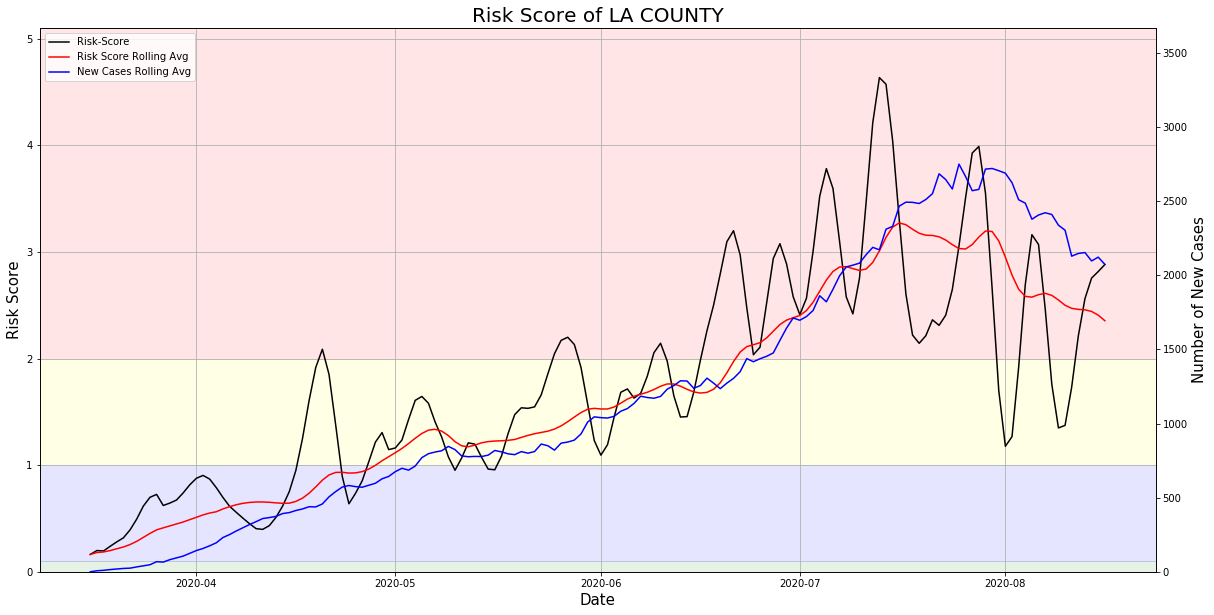

In [298]:
a=plot_rs('LA COUNTY', 20, '')


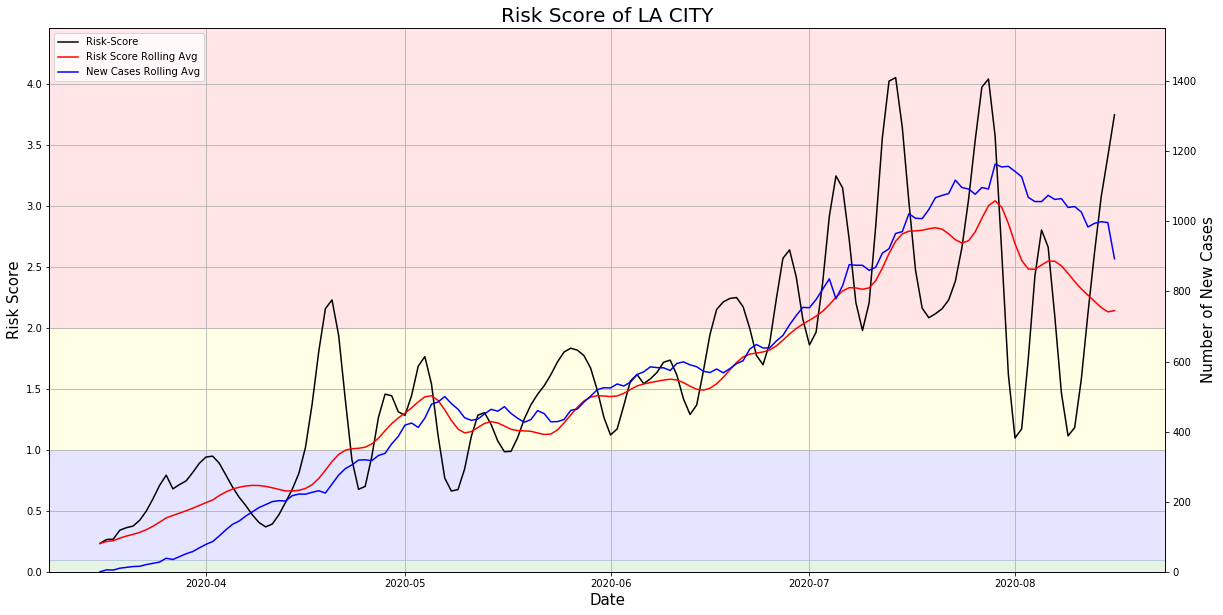

In [315]:
a=plot_rs('LA CITY', 18, '')

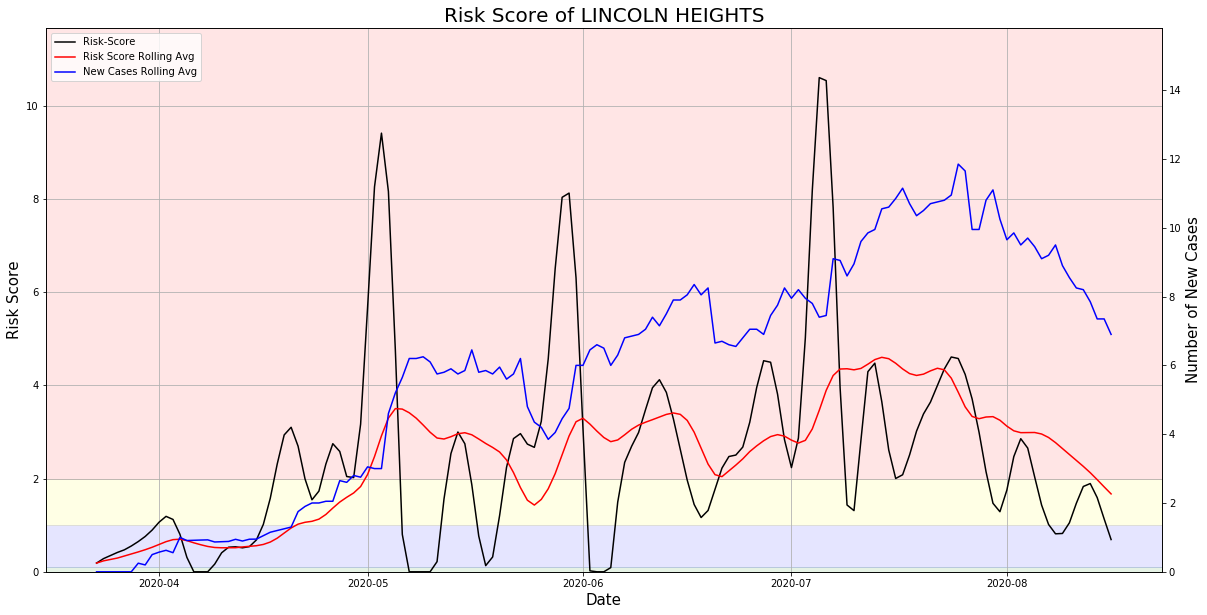

In [300]:
plot_rs('LINCOLN HEIGHTS',20,'')

In [201]:
# This function calculates trend of the Risk-Score at the most current data.
# Input:  length1, length2:    these parameters define the windows Risk Score differences
#         rolling_length:      window of the rolling average calculation
#         rolling_diff_length: window used to calculate the rolling average difference
# Output: recent:             this new dataframe contains list of all regions with calculated Risk Score Trends on the most current data

def rs_trend_summary(length1,length2,rolling_length,rolling_diff_length,rs_or_case):
    
    #intializing variables
    recent = pd.DataFrame()
    df_recent_1= pd.DataFrame()
    df_recent_2= pd.DataFrame()
    recent
    
    df_new=df.copy()
    regions = df_new['Region'].unique()
#     recent['Region']=regions
#     recent['Date']=recent['Region']
    
    
    for region in regions:
        df_region = df_new[df_new['Region']==region].sort_values('Time Stamp')
        
        recent_date = max(df_region['Time Stamp'])
#         recent.loc[recent['Region']=='Alhambra','Date'] = recent_date
        
#         length1_bef = pd.to_datetime(recent_date) - dt.timedelta(days=length1)
#         length2_bef = pd.to_datetime(recent_date) - dt.timedelta(days=length2)

#         df_1_before = df_region[df_region['Time Stamp'] == length1_bef]
#         df_2_before = df_region[df_region['Time Stamp'] == length2_bef]
        df_recent = df_region[df_region['Time Stamp']==recent_date]
        

#         string1= "RS_change_{}_Days".format(length1)
#         string2= "RS_change_{}_Days".format(length2)
        
#         if not df_1_before['Risk-Score'].empty:
#             df_recent[string1] = df_recent['Risk-Score'].iloc[0]-df_1_before['Risk-Score'].iloc[0]
#         else:
#             df_recent[string1] = df_recent['Risk-Score'].iloc[0]

#         if not df_2_before['Risk-Score'].empty:
#             df_recent[string2] = df_recent['Risk-Score'].iloc[0]-df_2_before['Risk-Score'].iloc[0]
#         else:
#             df_recent[string2] = df_recent['Risk-Score'].iloc[0]
        
        
        
        #Rolling Avreage
        if rs_or_case == 'rs':
            rolling_rs = df_region['Risk-Score'].rolling(rolling_length, min_periods=1).mean()

            recent_rolling_rs = rolling_rs.iloc[-1]


            length3 = 0 - rolling_diff_length -1

            past_rolling_rs = rolling_rs.iloc[length3]


            rolling_diff_rs = recent_rolling_rs - past_rolling_rs



            df_recent["Recent_Rolling_Average"] = recent_rolling_rs
            df_recent["Past_Rolling_Average"] = past_rolling_rs
            df_recent["Rolling_Difference"] = rolling_diff_rs
        

            threshhold=1/7

            if rolling_diff_rs > threshhold:
                df_recent['Trend_Abs'] = 'UP'
            if (rolling_diff_rs < threshhold) & (rolling_diff_rs > -threshhold):
                df_recent['Trend_Abs'] = '-'
            if rolling_diff_rs < -threshhold:
                df_recent['Trend_Abs'] = 'DOWN'

            percent_change = (rolling_diff_rs)*100/past_rolling_rs
            percent_threshhold = 5
            df_recent['percent_change']=round(percent_change)

            if percent_change > percent_threshhold:
                df_recent['Trend_%'] = 'UP'
            if (percent_change < percent_threshhold) & (percent_change > -percent_threshhold):
                df_recent['Trend_%'] = '-'
            if percent_change < -percent_threshhold:
                df_recent['Trend_%'] = 'DOWN'
        
#         if rolling_diff > threshhold:
#             df_recent['Risk_Trend_Abs'] = 'Red'
#         if (rolling_diff < threshhold) & (rolling_diff > -threshhold):
#             df_recent['Risk_Trend_Abs'] = 'Yellow'
#         if rolling_diff < -threshhold:
#             df_recent['Risk_Trend_Abs'] = 'Grenn'




        elif rs_or_case == 'case':
            rolling_case = df_region['New Cases'].rolling(rolling_length, min_periods=1).mean()
            recent_rolling_case = rolling_case.iloc[-1]
            length3 = 0 - rolling_diff_length -1
            past_rolling_case = rolling_case.iloc[length3]
            rolling_diff_case = recent_rolling_case - past_rolling_case

            df_recent["Recent_Rolling_Average"] = recent_rolling_case
            df_recent["Past_Rolling_Average"] = past_rolling_case
            df_recent["Rolling_Difference"] = rolling_diff_case
            
            threshhold= 3

            if rolling_diff_case > threshhold:
                df_recent['Trend_Abs'] = 'UP'
            if (rolling_diff_case < threshhold) & (rolling_diff_case > -threshhold):
                df_recent['Trend_Abs'] = '-'
            if rolling_diff_case < -threshhold:
                df_recent['Trend_Abs'] = 'DOWN'

            percent_change = (rolling_diff_case)*100/past_rolling_case
            percent_threshhold = 5
            df_recent['percent_change']=round(percent_change)

            if percent_change > percent_threshhold:
                df_recent['Trend_%'] = 'UP'
            if (percent_change < percent_threshhold) & (percent_change > -percent_threshhold):
                df_recent['Trend_%'] = '-'
            if percent_change < -percent_threshhold:
                df_recent['Trend_%'] = 'DOWN'
        
            
            
            
        
        recent = recent.append(df_recent).sort_values('Time Stamp')
        recent["Rank"] = recent["Rolling_Difference"].rank()
        recent = recent.sort_values('Rank')
#         recent=recent.drop(['index','Time Stamp','Latitude', 'Longitude','RS_change_3_Days','RS_change_14_Days'], axis=1)
        recent = recent[['Region','Rolling_Difference','Rank','Trend_Abs','percent_change','Trend_%']]
    return recent

In [214]:
recent = rs_trend_summary(12,13,12,1,'case')
recent

C:\Users\kwonk\anaconda3\lib\site-packages\ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\kwonk\anaconda3\lib\site-packages\ipykernel_launcher.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\kwonk\anaconda3\lib\site-packages\ipykernel_launcher.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

,Region,Rolling_Difference,Rank,Trend_Abs,percent_change,Trend_%
32846,PALMDALE,-3.250000,1.0,DOWN,-7.0,DOWN
32857,POMONA,-2.750000,2.0,-,-4.0,-
32813,LANCASTER,-1.916667,3.0,-,-5.0,DOWN
32844,PACOIMA,-1.833333,4.0,-,-6.0,DOWN
32761,EAST LOS ANGELES,-1.750000,5.0,-,-3.0,-
32773,FLORENCE-FIRESTONE,-1.583333,6.0,-,-3.0,-
32725,BOYLE HEIGHTS,-1.500000,8.0,-,-4.0,-
32909,VAN NUYS,-1.500000,8.0,-,-5.0,DOWN
32877,SANTA MONICA MOUNTAINS,-1.500000,8.0,-,2.0,-
32734,CARSON,-1.416667,10.5,-,-7.0,DOWN


In [222]:
a=calc_risk_trend('LA COUNTY',12)

In [236]:
min(a['Time Stamp'])-max(a['Time Stamp'])


Timedelta('-153 days +00:00:00')

In [267]:
153/16

9.5625

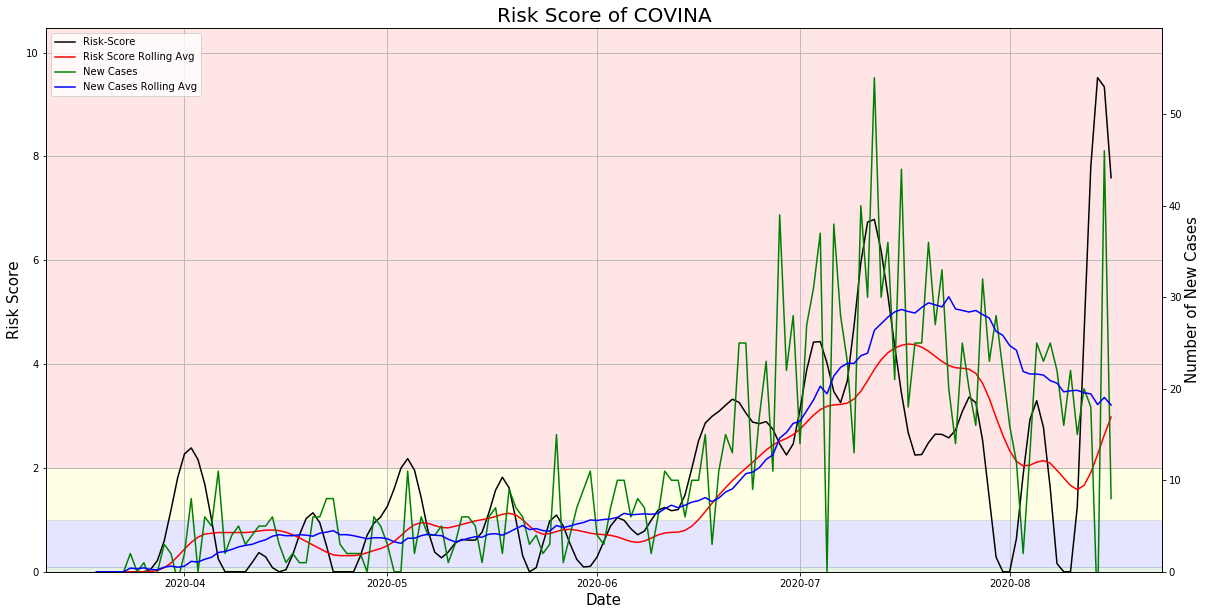

In [314]:
plot_rs('COVINA',18,'All')